# Deep Learning Aplicada em Imagens de Pulmoes para Idendificar Pneumonia

 Autor: Gabriel Fanini Silva

 Email: safari_faniga@hotmail.com
 Neste projeto iremos utilizar redes neurais afim de realizarmos previsões em imagens de raio-x de pulmões. Queremos que o modelo diga se uma imagem de um pulmão tem ou não pneumonia. E como ferramenta principal utilizaremos a biblioteca Keras para treinar nosso modelo e fazer previsões.
 
 Usaremos dois conjuntos de dados distintos, sendo que criaremos e treinaremos um modelo para cada conjunto. Não iremos misturar pois o método de captura de imagem pode ser diferente de uma clínica para outra. Estamos então simulando um projeto exclusivo para cada empresa.

# Bibliotecas

 Afim de gerarmos sempre os mesmos resultados, sem a presença da aleatoriadade, devemos rodar o seguinte código antes de todos os outros:

In [1]:
import numpy as np
import tensorflow as tf
import random as python_random

np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(1234)

 Segue então abaixo todas as bibliotecas que utilizaremos. Numpy, Keras e Matplotlib serão as principais usadas neste projeto.

In [2]:
import pandas as pd
import os
import glob
import keras.metrics
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import csv
import pydicom as dicom
import cv2
from keras.preprocessing import image
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image
from keras.models import Sequential 
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D 
from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from matplotlib.pyplot import figure
from scipy.ndimage import zoom
from sklearn.utils import class_weight
from keras.utils.vis_utils import plot_model

# Definições iniciais

 Definimos aqui as configurações básicas do código. Segue abaixo a explicação de cada uma. Mais a frente elas farão mais sentido.

Batch_size: número de exemplos usado em cada iteração no treino.

Zoom: quanto de zoom deve ser aplicado na imagem. 1.0 para visualizar toda a imagem, > 1.0 para dar zoom em direção ao centro da imagem e < 1.0 para se distanciar da imagem.

epocas: número de iterações.

dim: dimensão das imagens.

In [3]:
batch_size = 32
Zoom = 1.0
epocas = 100
dim = 64
kaggle2 = 1

# Kaggle1

 Iremos extrair dois conjuntos de dados do kaggle. Ambos se tratam de imagens de raio-x do pulmão de pacientes. Porém, por serem os mesmos tipos de dados, não iremos misturar pois o método de captura de imagem de hospital pra hospital pode ser diferente. O ideal é fazer análise e modelos preditivos para cada hospital, afim de nos adequarmos em cada situação diferente.

## Extração dos dados de treinamento

## Normal

 Aqui iremos extrair as imagens de treino, na qual são divididas em normal e pneumonia, e então converta-las para numpy, afim de utiliza-las no modelo de deep learning. Além disto, as informações serão salvas em arquivos do tipo npy e caso já exista tal arquivo, basta então acessa-los.
 
 Definimos inicialmente a função dar_zoom que aplica zoom em cada imagem convertida no formato numpy array. Já na função imagens_para_array, Cada imagem será convertida para o número dim * dim de pixels em 3 dimensões(pois as imagens são coloridas por 3 canais de cores diferentes) e inserimos as variáveis diretorio e salvando, que representam o diretório da pasta contendo as imagens e local onde salvar as novas imagens no formato de array, respectivamente. Caso o arquivo já exista, basta então carrega-lo utilizando a função np.load().
 
 Neste caso estamos extraindo as iamgens da pasta de treino com pulmões normais. Temos um total de 1341 imagens.
 
 Todos os arquivos deste projeto são diferenciados pelo Zoom e pela dimensão dim.
 
 Links:
 
 - https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
 - https://stackoverflow.com/questions/37119071/scipy-rotate-and-zoom-an-image-without-changing-its-dimensions

In [4]:
def dar_zoom(img, zoom_factor, **kwargs):

    altura, largura = img.shape[:2]
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    if zoom_factor < 1:

        zoom_altura = int(np.ceil(altura * zoom_factor))
        zoom_largura = int(np.ceil(largura * zoom_factor))
        cima = (altura - zoom_altura) // 2
        esquerda = (largura - zoom_largura) // 2

        saida = np.zeros_like(img)
        saida[cima:cima + zoom_altura, esquerda:esquerda + zoom_largura] = zoom(img, zoom_tuple, **kwargs)

    elif zoom_factor > 1:

        zoom_altura = int(np.ceil(altura / zoom_factor))
        zoom_largura = int(np.ceil(largura / zoom_factor))
        cima = (altura - zoom_altura) // 2
        esquerda = (largura - zoom_largura) // 2

        saida = zoom(img[cima:cima + zoom_altura, esquerda:esquerda + zoom_largura], zoom_tuple, **kwargs)

        trim_top = ((saida.shape[0] - altura) // 2)
        trim_left = ((saida.shape[1] - largura) // 2)
        saida = saida[trim_top:trim_top + altura, trim_left:trim_left + largura]

    else:
        saida = img
    return saida

def imagens_para_array(diretorio, salvando):
    imagens_treino_normal_array = []
    for filename in glob.glob(diretorio):
        img = image.load_img(filename, target_size = (dim, dim))
        img = image.img_to_array(img)
        img = dar_zoom(img, Zoom) / 255
        imagens_treino_normal_array.append(img)
        if len(imagens_treino_normal_array) % 1000 == 0:
            print("%s imagens convertidas" %(len(imagens_treino_normal_array)))
    imagens_treino_normal_array = np.array(imagens_treino_normal_array)
    np.save(salvando, imagens_treino_normal_array)
    
if os.path.isfile('arrays/normal/imagens_treino_normal_array_%s_%s.npy' %(Zoom, dim)) == False:
    imagens_para_array('dados/kaggle1/chest_xray/train/NORMAL/*.jpeg', 'arrays/normal/imagens_treino_normal_array_%s_%s.npy' %(Zoom, dim))
    imagens_treino_normal_array = np.load('arrays/normal/imagens_treino_normal_array_%s_%s.npy' %(Zoom, dim))
else:
    imagens_treino_normal_array = np.load('arrays/normal/imagens_treino_normal_array_%s_%s.npy' %(Zoom, dim))

print("Quantidade de imagens de treino de pulmões normais: %s" %(len(imagens_treino_normal_array)))

Quantidade de imagens de treino de pulmões normais: 1341


 Antes de convertermos também as imagens de pulmões com pneumonia, abaixo iremos comparar imagens originais, com determinados números de pixels estabelecidos nas definições iniciais, com as imagens convertidas pelo código acima com Zoom. Perceba então que quando damos zoom na imagem, focamos mais o centro e excluimos as beiradas, que não nos importam muito pois a pneumonia é identificada nos pulmões. Para Zoom < 1.0, a imagem se retrai ao meio, aumentando assim a borda preta ao redor da imagem.
 
 Neste projeto não usaremos zoom nas imagens(Zoom = 1.0).

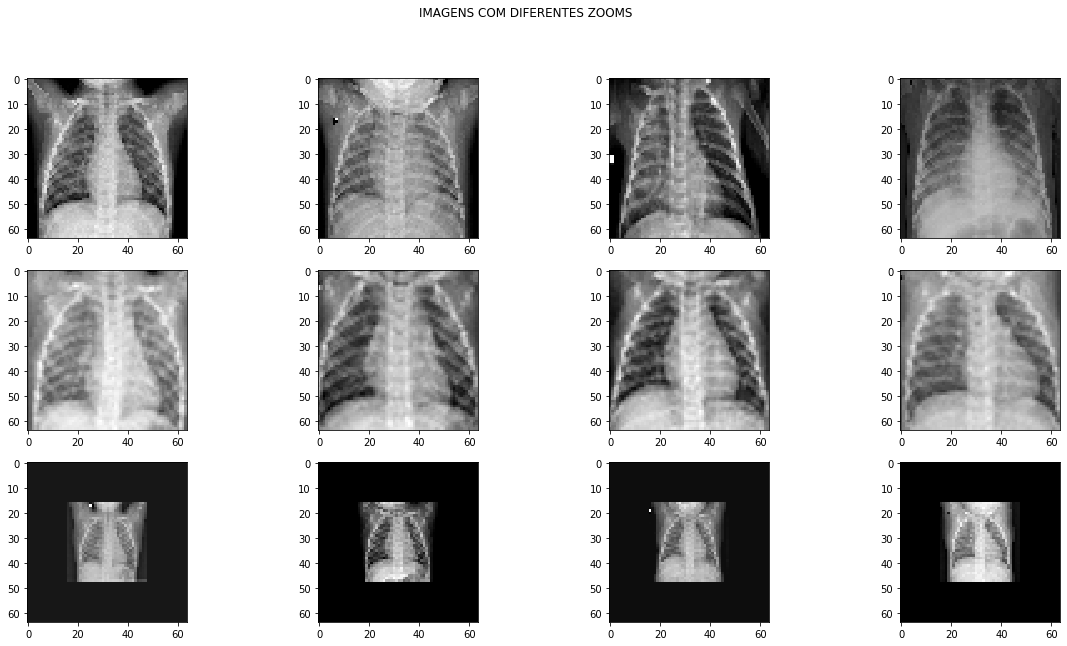

In [5]:
def diferentes_zooms():
    f, ax = plt.subplots(3,4, figsize = (20,10)) 
    
    ax[0,0].imshow(image.load_img('dados/kaggle1/chest_xray/train/NORMAL/IM-0135-0001.jpeg', target_size = (dim,dim)))
    ax[0,1].imshow(image.load_img('dados/kaggle1/chest_xray/train/NORMAL/IM-0137-0001.jpeg', target_size = (dim,dim)))
    ax[0,2].imshow(image.load_img('dados/kaggle1/chest_xray/train/PNEUMONIA/person10_bacteria_43.jpeg', target_size = (dim,dim)))
    ax[0,3].imshow(image.load_img('dados/kaggle1/chest_xray/train/PNEUMONIA/person100_virus_184.jpeg', target_size = (dim,dim)))

    ax[1,0].imshow(array_to_img(dar_zoom(imagens_treino_normal_array[0], 1.3)))
    ax[1,1].imshow(array_to_img(dar_zoom(imagens_treino_normal_array[1], 1.3)))
    ax[1,2].imshow(array_to_img(dar_zoom(imagens_treino_normal_array[2], 1.3)))
    ax[1,3].imshow(array_to_img(dar_zoom(imagens_treino_normal_array[3], 1.3)))

    ax[2,0].imshow(array_to_img(dar_zoom(imagens_treino_normal_array[0], 0.5)))
    ax[2,1].imshow(array_to_img(dar_zoom(imagens_treino_normal_array[1], 0.5)))
    ax[2,2].imshow(array_to_img(dar_zoom(imagens_treino_normal_array[2], 0.5)))
    ax[2,3].imshow(array_to_img(dar_zoom(imagens_treino_normal_array[3], 0.5)))
    plt.suptitle("IMAGENS COM DIFERENTES ZOOMS")
    plt.show()

diferentes_zooms()

## Pneumonia

 Segue abaixo a conversão das imagens de pulmões com pneumonia, que estão contidas em outra pasta com nome pneumonia. Mas como temos muito mais imagens de pulmões com pneumonia(3875 contra 1341), iremos balancear as classes, onde teremos um mesmo número de imagens tanto para pulmões normais, quanto para com os de pneumonia.

In [6]:
if os.path.isfile('arrays/pneumonia/imagens_treino_pneumonia_array_%s_%s.npy' %(Zoom, dim)) == False:
    imagens_para_array('dados/kaggle1/chest_xray/train/PNEUMONIA/*.jpeg', 'arrays/pneumonia/imagens_treino_pneumonia_array_%s_%s.npy' %(Zoom, dim))
    imagens_treino_pneumonia_array = np.load('arrays/pneumonia/imagens_treino_pneumonia_array_%s_%s.npy' %(Zoom, dim))
    print("Quantidade de imagens de treino de pulmões com pneumonia: %s" %(len(imagens_treino_pneumonia_array)))
    imagens_treino_pneumonia_array = imagens_treino_pneumonia_array[:len(imagens_treino_normal_array)]
    print("Quantidade de imagens balanceadas de treino de pulmões com pneumonia: %s" %(len(imagens_treino_pneumonia_array)))
else:
    imagens_treino_pneumonia_array = np.load('arrays/pneumonia/imagens_treino_pneumonia_array_%s_%s.npy' %(Zoom, dim))
    print("Quantidade de imagens de treino de pulmões com pneumonia: %s" %(len(imagens_treino_pneumonia_array)))
    imagens_treino_pneumonia_array = imagens_treino_pneumonia_array[:len(imagens_treino_normal_array)]
    print("Quantidade de imagens balanceadas de treino de pulmões com pneumonia: %s" %(len(imagens_treino_pneumonia_array)))

treino = np.concatenate([imagens_treino_normal_array, imagens_treino_pneumonia_array])
print("Quantidade de imagens para o treino:", len(treino))

Quantidade de imagens de treino de pulmões com pneumonia: 3875
Quantidade de imagens balanceadas de treino de pulmões com pneumonia: 1341
Quantidade de imagens para o treino: 2682


## Classe

 Além disto precisamos especificar a classe de cada imagem, 0 para pulmões normais e 1 para pulmões com pneumonia.

In [7]:
classe_treino = np.zeros(len(imagens_treino_normal_array) + len(imagens_treino_pneumonia_array))
for i in range(len(imagens_treino_normal_array), len(classe_treino)):
    classe_treino[i] = 1
    
pd.DataFrame(classe_treino, columns = ["Rótulo de Cada Imagem de Treino"])

,Rótulo de Cada Imagem de Treino
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
2677,1.0
2678,1.0
2679,1.0
2680,1.0


# Extração dos Dados de Teste

 Assim como temos a pasta train onde encontram-se as imagens para o treino, também temos a pasta test onde temos as imagens nas quais iremos testar o modelo e calcularmso as métricas para a avaliação. O processo de extração é o mesmo para os dados de treino.

In [8]:
if os.path.isfile('arrays/normal/imagens_teste_normal_array_%s_%s.npy' %(Zoom, dim)) == False:
    imagens_para_array('dados/kaggle1/chest_xray/test/NORMAL/*.jpeg', 'arrays/normal/imagens_teste_normal_array_%s_%s.npy' %(Zoom, dim))
    imagens_teste_normal_array = np.load('arrays/normal/imagens_teste_normal_array_%s_%s.npy' %(Zoom, dim))
else:
    imagens_teste_normal_array = np.load('arrays/normal/imagens_teste_normal_array_%s_%s.npy' %(Zoom, dim))
print("Quantidade de imagens de teste de pulmões normais: %s" %(len(imagens_teste_normal_array)))

if os.path.isfile('arrays/pneumonia/imagens_teste_pneumonia_array_%s_%s.npy' %(Zoom, dim)) == False:
    imagens_para_array('dados/kaggle1/chest_xray/test/PNEUMONIA/*.jpeg', 'arrays/pneumonia/imagens_teste_pneumonia_array_%s_%s.npy' %(Zoom, dim))
    imagens_teste_pneumonia_array = np.load('arrays/pneumonia/imagens_teste_pneumonia_array_%s_%s.npy' %(Zoom, dim))
else:
    imagens_teste_pneumonia_array = np.load('arrays/pneumonia/imagens_teste_pneumonia_array_%s_%s.npy' %(Zoom, dim))
print("Quantidade de imagens de teste de pulmões com pneumonia: %s" %(len(imagens_teste_pneumonia_array)))

teste = np.concatenate([imagens_teste_normal_array, imagens_teste_pneumonia_array])
print("Quantidade de imagens para o teste:", len(teste))

Quantidade de imagens de teste de pulmões normais: 234
Quantidade de imagens de teste de pulmões com pneumonia: 390
Quantidade de imagens para o teste: 624


## Classe

In [9]:
classe_teste = np.zeros(len(imagens_teste_normal_array) + len(imagens_teste_pneumonia_array))
for i in range(len(imagens_teste_normal_array), len(classe_teste) - 1):
    classe_teste[i] = 1
    
pd.DataFrame(classe_teste, columns = ["Rótulo de Cada Imagem de Teste"])

,Rótulo de Cada Imagem de Teste
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
619,1.0
620,1.0
621,1.0
622,1.0


# Validação

 Observe que temos 8 imagens de pulmões normais e 8 imagens de pulmões com pneumonia para validar o treinamento. Esta é uma quantidade muito baixa. Poderiamos então retirar algumas imagens de treino e adiciona-las aos dados de validação ou então aplicar split_validation no treinamento. Por exemplo, utilizar 20% dos dados de treino para a validação. Mas, neste projeto iremos seguir as regras e utilizar apenas estas 16 imagens para a validação.

In [10]:
if os.path.isfile('arrays/normal/imagens_validacao_normal_array_%s_%s.npy' %(Zoom, dim)) == False:
    imagens_para_array('dados/kaggle1/chest_xray/val/NORMAL/*.jpeg', 'arrays/normal/imagens_validacao_normal_array_%s_%s.npy' %(Zoom, dim))
    imagens_validacao_normal_array = np.load('arrays/normal/imagens_validacao_normal_array_%s_%s.npy' %(Zoom, dim))
else:
    imagens_validacao_normal_array = np.load('arrays/normal/imagens_validacao_normal_array_%s_%s.npy' %(Zoom, dim))
print("Quantidade de imagens de validação de pulmões normais: %s" %(len(imagens_validacao_normal_array)))

if os.path.isfile('arrays/pneumonia/imagens_validacao_normal_array_%s_%s.npy' %(Zoom, dim)) == False:
    imagens_para_array('dados/kaggle1/chest_xray/val/PNEUMONIA/*.jpeg', 'arrays/pneumonia/imagens_validacao_normal_array_%s_%s.npy' %(Zoom, dim))
    imagens_validacao_pneumonia_array = np.load('arrays/pneumonia/imagens_validacao_normal_array_%s_%s.npy' %(Zoom, dim))
else:
    imagens_validacao_pneumonia_array = np.load('arrays/pneumonia/imagens_validacao_normal_array_%s_%s.npy' %(Zoom, dim))
print("Quantidade de imagens de validação de pulmões com pneumonia: %s" %(len(imagens_validacao_pneumonia_array)))

validacao = np.concatenate([imagens_validacao_normal_array, imagens_validacao_pneumonia_array])
print("Quantidade de imagens para a validação:", len(validacao))

Quantidade de imagens de validação de pulmões normais: 8
Quantidade de imagens de validação de pulmões com pneumonia: 8
Quantidade de imagens para a validação: 16


## Classe

In [11]:
classe_validacao = np.zeros(len(imagens_validacao_normal_array) + len(imagens_validacao_pneumonia_array))
for i in range(len(imagens_validacao_normal_array), len(classe_validacao) - 1):
    classe_validacao[i] = 1

pd.DataFrame(classe_validacao, columns = ["Rótulo de Cada Imagem de Validação"])

,Rótulo de Cada Imagem de Validação
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,1.0
9,1.0


# Kaggle2

 Aqui usaremos outro conjunto de dados e aplicaremos basicamente o mesmo código acima, com o detalhe que aqui todas as imagens estão em uma única pasta e existe um arquivo csv que indica a classe de cada imagem.

## Convertendo DCM para JPEG

 Além disto as imagens estão no formato dcim e precisamos então converte-las para jpeg, afim de então realizar novamente a conversão para matrizes. A função dicom_para_jpeg() abaixo realiza tal conversão.

 Links:
 
 - https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data
 - https://medium.com/@vivek8981/dicom-to-jpg-and-extract-all-patients-information-using-python-5e6dd1f1a07d

In [12]:
def dicom_para_jpeg(folder, out):    
    PNG = False
    folder_path = folder
    jpg_folder_path = out
    images_path = os.listdir(folder_path)
    # download this file from the given link # https://github.com/vivek8981/DICOM-to-JPG
    dicom_image_description = pd.read_csv("dicom_image_description.csv")

    with open('Patient_Detail.csv', 'w', newline ='') as csvfile:
        fieldnames = list(dicom_image_description["Description"])
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(fieldnames)
        for n, image in enumerate(images_path):
            ds = dicom.dcmread(os.path.join(folder_path, image))
            rows = []
            pixel_array_numpy = ds.pixel_array
            if PNG == False:
                image = image.replace('.dcm', '.jpeg')
            else:
                image = image.replace('.dcm', '.png')
            cv2.imwrite(os.path.join(jpg_folder_path, image), pixel_array_numpy)
            if n % 1000 == 0:
                print('{} imagens convertidas!'.format(n))

            for field in fieldnames:
                if ds.data_element(field) is None:
                    rows.append('')
                else:
                    x = str(ds.data_element(field)).replace("'", "")
                    y = x.find(":")
                    x = x[y + 2:]
                    rows.append(x)
            writer.writerow(rows)
    
    print("Todas as imagens convertidas!")

#dicom_para_jpeg("dados/kaggle2/stage_2_train_images", "dados/kaggle2/treino_jpeg")

## Treino e Teste

 Perceba que neste conjunto de dados temos muito mais imagens que o primeiro. Além disto também temos um data set desbalanceado.

In [13]:
if os.path.isfile('arrays/extra/imagens_array_treino_%s_%s.npy' %(Zoom, dim)) == False:
    imagens_para_array('dados/kaggle2/treino_jpeg/*.jpeg', 'arrays/extra/imagens_array_treino_%s_%s.npy' %(Zoom, dim))
    imagens_extra_array_treino = np.load('arrays/extra/imagens_array_treino_%s_%s.npy' %(Zoom, dim))
else:
    imagens_extra_array_treino = np.load('arrays/extra/imagens_array_treino_%s_%s.npy' %(Zoom, dim))

treino_extra = imagens_extra_array_treino[0: int(0.7 * len(imagens_extra_array_treino))]
teste_extra = imagens_extra_array_treino[int(0.7 * len(imagens_extra_array_treino)) + 1:]
print("Quantidade de imagens extras de treino: %s" %(len(treino_extra)))
print("Quantidade de imagens extras de teste: %s" %(len(teste_extra)))

Quantidade de imagens extras de treino: 18678
Quantidade de imagens extras de teste: 8005


# Classe

 Afim de extrairmos as classes para as respectivas imagens precisamos primeiro extrair o id de cada paciente e então verificarmos qual classe pertence a partir do arquivo csv que contém as informações de cada paciente.

In [14]:
from os import listdir
from os.path import isfile, join

label_imagens = [f[0:-4] for f in listdir("dados/kaggle2/stage_2_train_images/") if isfile(join("dados/kaggle2/stage_2_train_images/", f))]
label_imagens = pd.DataFrame(label_imagens, columns = ["patientId"])
label_imagens

,patientId
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6
1,000924cf-0f8d-42bd-9158-1af53881a557
2,000db696-cf54-4385-b10b-6b16fbb3f985
3,000fe35a-2649-43d4-b027-e67796d412e0
4,001031d9-f904-4a23-b3e5-2c088acd19c6
...,...
26679,fffb2395-8edd-4954-8a89-ffe2fd329be3
26680,fffba05a-1635-4545-9bbd-57ad4cfe8d27
26681,fffc95b5-605b-4226-80ab-62caec682b22
26682,fffcff11-d018-4414-971a-a7cefa327795


 Abaixo vemos que no arquivo csv temos as informações de cada paciente, mostrando a localização da pneumonia(não tenho certeza sobre isto pois minha area não é medicina) e a classe(na variável Target, onde 0 é normal e 1 pneumonia).

In [15]:
classe_extra = pd.read_csv('dados/kaggle2/stage_2_train_labels.csv')
classe_extra = classe_extra.drop_duplicates(subset = ["patientId"], keep = "first")
classe_extra = classe_extra.reset_index(drop = True)
classe = pd.merge(left = label_imagens, right = classe_extra, how = 'inner', left_on = 'patientId', right_on = 'patientId')
classe = classe.reset_index(drop = True)
classe

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0
2,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1
3,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1
4,001031d9-f904-4a23-b3e5-2c088acd19c6,66.0,160.0,373.0,608.0,1
...,...,...,...,...,...,...
26679,fffb2395-8edd-4954-8a89-ffe2fd329be3,177.0,285.0,225.0,529.0,1
26680,fffba05a-1635-4545-9bbd-57ad4cfe8d27,NaN,NaN,NaN,NaN,0
26681,fffc95b5-605b-4226-80ab-62caec682b22,NaN,NaN,NaN,NaN,0
26682,fffcff11-d018-4414-971a-a7cefa327795,NaN,NaN,NaN,NaN,0


 Agora temos todas as classes equilibradas e cada imagem relacionada respectivamente com sua classe.

In [16]:
classe_extra_treino = classe[0: int(0.7 * len(imagens_extra_array_treino))]["Target"]
classe_extra_teste = classe[int(0.7 * len(imagens_extra_array_treino)) + 1:]["Target"]
classe_extra_teste = classe_extra_teste.reset_index(drop = True)

extra_normal = []
extra_pneumonia = []
classe_normal = []
classe_pneumonia = []
for i in range(len(classe_extra_treino)):
    if classe_extra_treino[i] == 0:
        extra_normal.append(treino_extra[i])
        classe_normal.append(0)
    else:
        extra_pneumonia.append(treino_extra[i])
        classe_pneumonia.append(1)

extra_normal = extra_normal[:len(classe_pneumonia)]
classe_normal = classe_normal[:len(classe_pneumonia)]
print("Quantidade e imagens normais para o treinamento:",len(extra_normal))
print("Quantidade de imagens com pneumonia para o treinamento:",len(extra_pneumonia))

treino_extra = np.concatenate([extra_normal, extra_pneumonia])
classe_extra_treino = np.concatenate([classe_normal, classe_pneumonia])

Quantidade e imagens normais para o treinamento: 4606
Quantidade de imagens com pneumonia para o treinamento: 4606


 Finalizamos então criando os dados de validação, onde retiramos 100 imagens do treinamento.

In [17]:
validacao_extra = np.concatenate([extra_normal[:50], extra_pneumonia[:50]])
classe_validacao_extra = np.concatenate([classe_normal[:50], classe_pneumonia[:50]])

treino_extra = np.concatenate([extra_normal[51:], extra_pneumonia[51:]])
classe_extra_treino = np.concatenate([classe_normal[51:], classe_pneumonia[51:]])

print("Quantidade de imagens para o treinamento:",len(treino_extra))
print("Quantidade de classes para o treinamento:",len(classe_extra_treino))
print("Quantidade de imagens para a validação:",len(validacao_extra))
print("Quantidade de classes para a validação:",len(classe_validacao_extra))

Quantidade de imagens para o treinamento: 9110
Quantidade de classes para o treinamento: 9110
Quantidade de imagens para a validação: 100
Quantidade de classes para a validação: 100


# MODELO

 Vamos então criar e treinar nosso modelo de deep learning. Sobre cada termo utilizado no modelo, deixo o link abaixo do deep learning book que explica detalhadamente cada termo. De qualquer forma, o importante aqui é o callback. Quando treinamos nosso modelo, ele irá tentar se adaptar aos dados de treino, ou seja, irá encontrar pesos de forma que melhor faça previsões nos dados de treino. O problema disto é que o modelo pode se adaptar demais a estes dados e então faça previsões ruins em novos dados. Para isto devemos analisar os dados de validação que são os dados que são testados enquanto o modelo é treinado. Programaremos o modelo para parar quando a acurácia nos dados de validação será de 99%. E para interrompermos o programa basta utilizarmos a função abaixo.
 
 Além disto estamos usando EarlyStopping, onde o treinamento é interrompido após 10 épocas caso a acurácia não aumente e o checkpoint que grava os pesos do modelo que gerou o melhor resultado, em um arquivo .h5. Logo, quando iniciarmos uma nova sessão no python, carregamos estes pesos e fazemos as previsões.

In [18]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs = None): 
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold and logs["accuracy"] >= self.threshold:
            self.model.stop_training = True

if kaggle2 == 2:
    treino = treino_extra
    classe_treino = classe_extra_treino
    teste = teste_extra
    classe_teste = classe_extra_teste
    validacao = validacao_extra
    classe_validacao = classe_validacao_extra
    
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', np.unique(classe_treino), classe_treino)))
            
stop1 = MyThresholdCallback(threshold = 0.98)            
stop2 = EarlyStopping(monitor = "val_accuracy", patience = 10, mode = "max")
stop3 = ModelCheckpoint("modelos/checkpoint/model_%r_%r_%r.h5" %(Zoom, dim, kaggle2), monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')

def Model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape = treino.shape[1:], activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Flatten())
    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dense(units = 1, activation = 'sigmoid'))
    
    model.compile(optimizer = 'adam',
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy', keras.metrics.Recall()])

    if (os.path.isfile("modelos/modelo/model_%r_%r_%r.h5" %(Zoom, dim, kaggle2)) == False 
        or os.path.isfile("modelos/epocas_historico/final_epochs_%r_%r_%r.npy" %(Zoom, dim, kaggle2)) == False
        or os.path.isfile("modelos/epocas_historico/final_history_%r_%r_%r.npy" %(Zoom, dim, kaggle2)) == False):
        final = model.fit(treino, classe_treino,
                  callbacks = [stop1, stop2, stop3],
                  validation_data = (validacao, classe_validacao),
                  shuffle = True,
                  epochs = epocas,
                  class_weight = class_weights,
                  batch_size = batch_size)

        model.save("modelos/modelo/model_%r_%r_%r.h5" %(Zoom, dim, kaggle2))
        np.save("modelos/epocas_historico/final_epochs_%r_%r_%r.npy" %(Zoom, dim, kaggle2) ,final.epoch)
        np.save("modelos/epocas_historico/final_history_%r_%r_%r.npy" %(Zoom, dim, kaggle2), final.history)
        epoca = np.load("modelos/epocas_historico/final_epochs_%r_%r_%r.npy" %(Zoom, dim, kaggle2), allow_pickle = True)
        historico = np.load("modelos/epocas_historico/final_history_%r_%r_%r.npy" %(Zoom, dim, kaggle2), allow_pickle = True)
    else:
        if os.path.isfile("modelos/checkpoint/model_%r_%r_%r.h5" %(Zoom, dim, kaggle2)) == True:
            model.load_weights("modelos/checkpoint/model_%r_%r_%r.h5" %(Zoom, dim, kaggle2))
        else:
            model = tf.keras.models.load_model("modelos/modelo/model_%r_%r_%r.h5" %(Zoom, dim, kaggle2))
        epoca = np.load("modelos/epocas_historico/final_epochs_%r_%r_%r.npy" %(Zoom, dim, kaggle2), allow_pickle = True)
        historico = np.load("modelos/epocas_historico/final_history_%r_%r_%r.npy" %(Zoom, dim, kaggle2), allow_pickle = True)
    
    return model, epoca, historico
    
model, epoca, historico = Model()

C:\Users\GAMER\anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0. 1.], y=[0. 0. 0. ... 1. 1. 1.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


 Abaixo temos ao longo das épocas a acurácia, recall e o loss dos dados de treino e de validação. Como treinamos poucas vezes, não fica claro se parar na época 5 foi a melhor escolha. Poderiamos então deixar o modelo treinando varias épocas e verificar em qual época ele desempenhou a melhor taxa de acertos nos dados de validação.

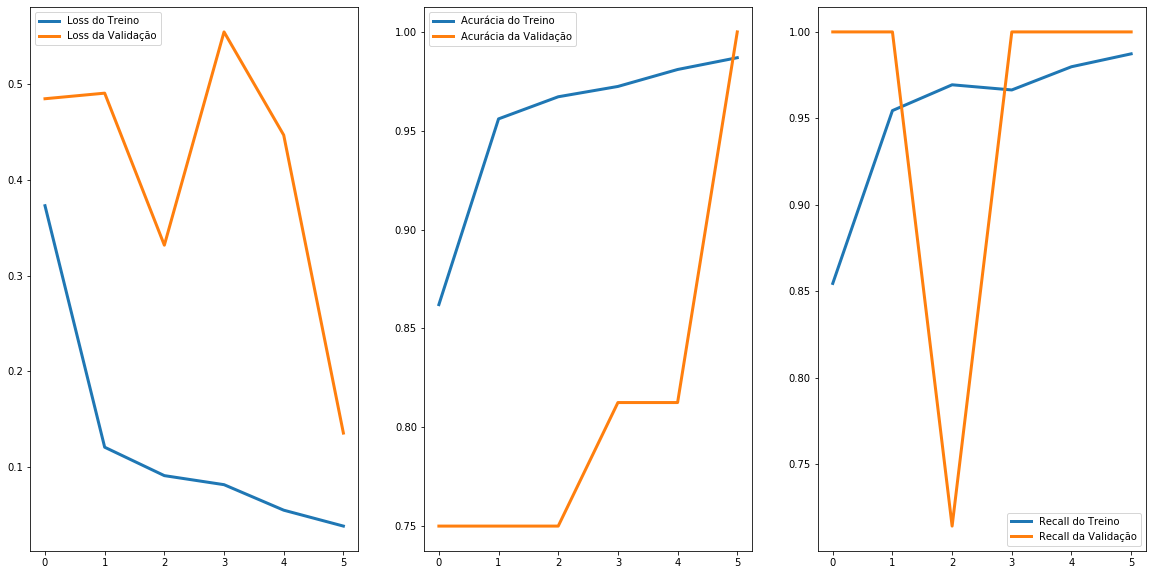

In [19]:
def plotar_modelo(epoca, historico):
    plt.figure(figsize = (20,10))
    plt.subplot(131)
    plt.plot(epoca, historico.tolist()['loss'], label = "Loss do Treino", linewidth = 3)
    plt.plot(epoca, historico.tolist()['val_loss'], label = "Loss da Validação", linewidth = 3)
    plt.legend()

    plt.subplot(132)
    plt.plot(epoca, historico.tolist()['accuracy'], label = "Acurácia do Treino", linewidth = 3)
    plt.plot(epoca, historico.tolist()['val_accuracy'], label = "Acurácia da Validação", linewidth = 3)
    plt.legend()

    plt.subplot(133)
    plt.plot(epoca, historico.tolist()['recall'], label = "Recall do Treino", linewidth = 3)
    plt.plot(epoca, historico.tolist()['val_recall'], label = "Recall da Validação", linewidth = 3)
    plt.legend()

    plt.show()

plotar_modelo(epoca, historico)

# Estrutura

 Segue abaixo a estrutura de todo o modelo. Onde está o simbolo ?, é entendido por None.

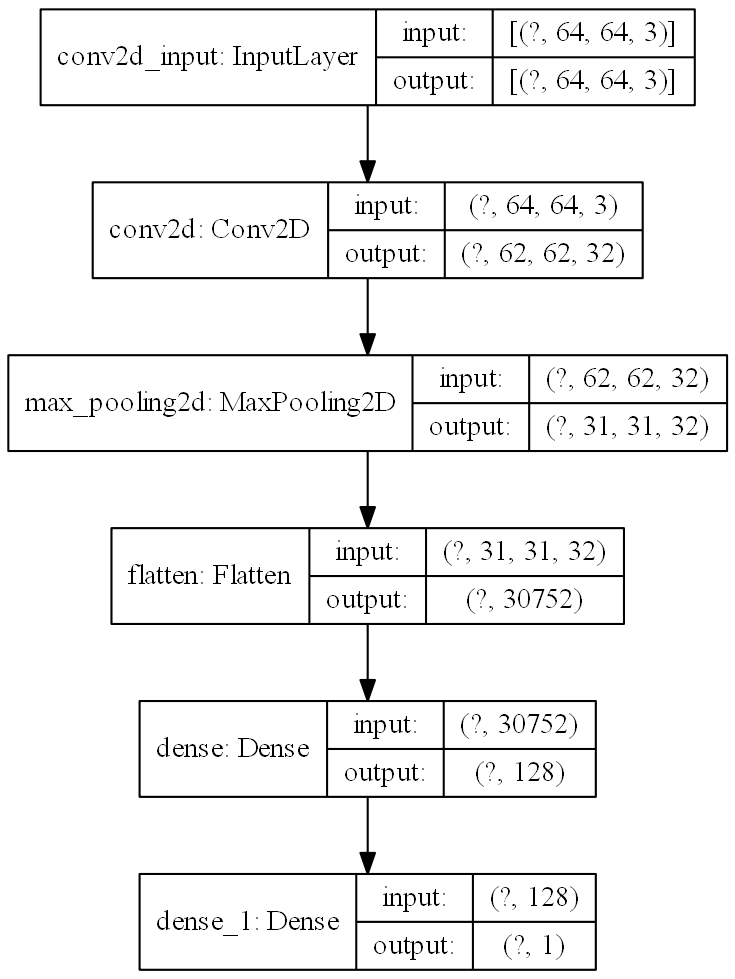

In [20]:
plot_model(model,
           show_shapes = True,
           to_file = "modelos/visualizacao/model_plot.png",
           show_layer_names = True,
           dpi = 150)

# Previsões

## Teste

 Como modelo treinado, basta então realizarmos as previsões nos dados de teste. Mas perceba que a função de ativação da saída do nosso modelo é a sigmoid, que é definida por 1 / (1 + e ** (-x) ), variando então entre 0 e 1. Mas as classes no nosso problema são 0 e 1. Precisamos então converter o resultado de cada valor da sigmoide entre 0 e 1 para 0 ou 1. Basta então utilziarmos um trheshould( = 0.5), ou seja, caso a previsão seja maior que 0.5, será 1 e caso seja menor ou igual, 0.

 Analisando as previsões, vemos que nosso modelo foi muito bem em acurácia e recall mas nem tanto em precisão e isto quer dizer que nosso modelo tende a ser mais acertivo para imagens normais, ou seja, se uma pessoa não está com pneumonia, então o modelo afirma isto com mais certeza do que quando a pessoa tem pneumonia. E neste caso isto é bom pois mais vale dizer que um paciente está doente, mas não está, do que dizer que o paciente não está doente, mas que na verdade está.

_______________________________________________________ACURÁCIA:  0.8237179487179487
_______________________________________________________RECALL:  0.9562982005141388
_______________________________________________________PRECISÃO:  0.8
_______________________________________________________F1:  0.8711943793911008
_______________________________________________________BINARY CROSS ENTROPY LOSS:  2.346114


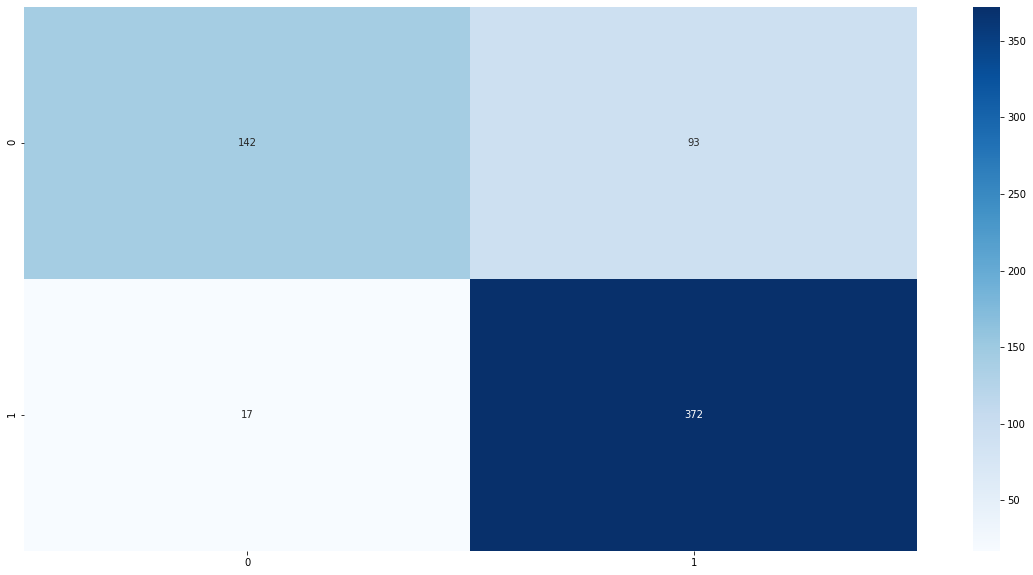

In [21]:
from sklearn.metrics import log_loss
from math import log

def previsoes(modelo, arquivo_metricas, prever, classe):

    resultados = modelo.predict(prever)
    resultados = tf.greater(resultados, .5)
    resultados = [1 if resultados[i] == True else 0 for i in range(len(resultados))]
    matriz = confusion_matrix(classe, resultados)

    metricas = [accuracy_score(classe, resultados),
                recall_score(classe, resultados),
                precision_score(classe, resultados),
                f1_score(classe, resultados),
                tf.keras.losses.BinaryCrossentropy()]
    
    np.save(arquivo_metricas, np.array(metricas))
    
    print("_______________________________________________________ACURÁCIA: ", metricas[0])
    print("_______________________________________________________RECALL: ", metricas[1])
    print("_______________________________________________________PRECISÃO: ", metricas[2])
    print("_______________________________________________________F1: ", metricas[3])
    print("_______________________________________________________BINARY CROSS ENTROPY LOSS: ", metricas[4](classe_teste, modelo.predict(teste)).numpy())

    figure(figsize = (20,10))
    sns.heatmap(matriz, annot = True, cmap = "Blues", fmt = 'g')

previsoes(model, "resultados/model_%s_%r_%r_teste.npy" %(Zoom, dim, kaggle2), teste, classe_teste)

## Todos os Dados

 Sabemos que não é recomendado se basear na previsão dos próprios dados de treino, maas de qualquer forma segue abaixo a previsão de todas as imagens que utilizamos neste projeto. Basta concatenar os dados de treino, teste e validação e executar a previsão.

In [22]:
tudo = np.concatenate([treino, teste, validacao])
classe_tudo = np.concatenate([classe_treino, classe_teste, classe_validacao])

#previsoes(model, "resultados/model_%s_%r_%r_tudo.npy" %(Zoom, dim, kaggle2), tudo, classe_tudo)

## Previsão Única

 Caso você queira fazer a previsão de apenas uma iamgem, um detalhe importante é adicionar a esta imagem uma dimensão. No código abaixo estamos tentando prever a primeira imagem de teste(teste[0]) e usando np.expand_dims() para adicionar a dimensão a imagem. Observe que o valor encontrado é menor que 0.5, logo é 0(pulmão normal), mostrando que o modelo acertou ao prever esta imagem.
 
 Observe que a dimensão da nova imagem é 1 x 150 x 150 x 3.

Links:

- https://stackoverflow.com/questions/43017017/keras-model-predict-for-a-single-image

In [23]:
prever = teste[0]
prever = np.expand_dims(prever, axis=0)
print("Nosso modelo previu", model.predict(prever)[0][0], "para a primeira imagem de teste e sua classe original é", classe_teste[0])
print("Dimensão da imagem:", prever.shape)

Nosso modelo previu 0.067268044 para a primeira imagem de teste e sua classe original é 0.0
Dimensão da imagem: (1, 64, 64, 3)
